# Parametros para Simulación
La incorporación de simular los parametros que obtenemos y compararlo a una simulación del modelo me parece un paso natural.
Parte de nuestro modelo va de que el numeor de SEU observados $N_{obs}$ dependerá del flujo de hadrones de lata energia HEH: $\Phi$, del tiempo de limpieza o reset $T_\text{scrub}$. el numero de sub sistemas TMR $N_{triads}$ y la eficiencia del detector $\eta_{eff}$ que dependerá del tiempo puerto.

In [ ]:
El calculo de derivadas no es muy util, pues puede existir un rango en donde los datos se encuentran con un beam apagado y otros con beam encendido

es necesario considerar dos cosas

1.- Que tenemos el beam encendido dada las condiciones

2- Que tomamos ventanas para suavizar los valores del beam, puesto que peuqeñas variaciones pueden ser fatales, consdierando además

In [10]:
# Cell 1: Imports & Global Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de estilo 'RadAnalysis'
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.5)
plt.rcParams['figure.figsize'] = (14, 6)

# Rutas a los archivos (Definición de Diccionarios para escalabilidad)
FILES_CONFIG = {
    '2': {
        'beam': '1_data/beam2.csv',
        'cpld': '1_data/dmm_cpld_run2.csv'
    },
    '3': {
        'beam': '1_data/beam3.csv',
        'cpld': '1_data/dmm_cpld_run3.csv'
    }
}

# Constantes Físicas del Sistema
TRIADS_COUNT = 13
SCRUB_MEAN_THEORETICAL = 0.5  # segundos
SCRUB_STD_THEORETICAL = 0.05   # segundos

In [22]:
# Cell 2: Ingesta y Limpieza de Datos (Multi-Run Support)
def load_and_prep_data(run='both'):
    """
    Carga y prepara los datos del haz y del CPLD.
    
    Args:
        run (str/int): '2', '3', o 'both'/'ambas'.
    
    Returns:
        tuple: (df_beam_combined, df_cpld_combined)
    """
    run_str = str(run).lower()
    runs_to_load = []
    
    # Definir qué runs cargar
    if run_str in ['2', 'run2']:
        runs_to_load = ['2']
    elif run_str in ['3', 'run3']:
        runs_to_load = ['3']
    elif run_str in ['both', 'ambas', 'all', 'todo']:
        runs_to_load = ['2', '3']
    else:
        raise ValueError(f"Run '{run}' no reconocido. Use '2', '3', o 'both'.")

    beam_dfs = []
    cpld_dfs = []

    # Helper interno para normalizar tiempos
    def standardize_timestamp(df, source_name):
        time_col = None
        candidates = ['Time', 'timestamp', 'Date', 'time', 'Datetime']
        for col in candidates:
            if col in df.columns:
                time_col = col
                break
        
        if time_col:
            df['timestamp'] = pd.to_datetime(df[time_col])
        else:
            # Fallback a índice si es datetime
            try:
                df.index = pd.to_datetime(df.index)
                df['timestamp'] = df.index
            except:
                raise ValueError(f"No se pudo detectar timestamp en {source_name}")
        return df.sort_values('timestamp')

    print(f"=== Iniciando Carga de Datos para Run(s): {runs_to_load} ===")

    for r_id in runs_to_load:
        # 1. Cargar Beam Data
        path_beam = FILES_CONFIG[r_id]['beam']
        try:
            print(f"  -> Cargando Beam Run {r_id}: {path_beam}")
            df_b = pd.read_csv(path_beam)
            df_b = standardize_timestamp(df_b, f"Beam Run {r_id}")
            df_b['run_id'] = int(r_id)  # Trazabilidad
            beam_dfs.append(df_b)
        except Exception as e:
            print(f"  [ERROR] Fallo cargando Beam {r_id}: {e}")

        # 2. Cargar CPLD Data
        path_cpld = FILES_CONFIG[r_id]['cpld']
        try:
            print(f"  -> Cargando CPLD Run {r_id}: {path_cpld}")
            df_c = pd.read_csv(path_cpld)
            df_c = standardize_timestamp(df_c, f"CPLD Run {r_id}")
            df_c['run_id'] = int(r_id)  # Trazabilidad
            cpld_dfs.append(df_c)
        except Exception as e:
            print(f"  [ERROR] Fallo cargando CPLD {r_id}: {e}")

    # 3. Concatenación y Manejo de Discontinuidades
    if not beam_dfs or not cpld_dfs:
        print("Error Crítico: No se cargaron datos.")
        return None, None

    df_beam_total = pd.concat(beam_dfs).sort_values('timestamp').reset_index(drop=True)
    df_cpld_total = pd.concat(cpld_dfs).sort_values('timestamp').reset_index(drop=True)

    # Verificación de saltos temporales (Gap Analysis)
    if len(runs_to_load) > 1:
        gap = df_beam_total['timestamp'].diff().max()
        print(f"\n[INFO] Concatenación completada. Salto temporal máximo detectado: {gap}")
        print("Advertencia: Al calcular derivadas (flujo), recuerde filtrar delta_t > umbral para ignorar el salto entre runs.")

    print(f"\nResumen Final:")
    print(f" - Beam Samples Totales: {len(df_beam_total)}")
    print(f" - CPLD Events Totales: {len(df_cpld_total)}")
    print(f" - Rango Temporal: {df_beam_total['timestamp'].min()} a {df_beam_total['timestamp'].max()}")

    return df_beam_total, df_cpld_total

# Ejecución
df_beam, df_cpld = load_and_prep_data(run='2')

=== Iniciando Carga de Datos para Run(s): ['2'] ===
  -> Cargando Beam Run 2: 1_data/beam2.csv
  -> Cargando CPLD Run 2: 1_data/dmm_cpld_run2.csv

Resumen Final:
 - Beam Samples Totales: 9999
 - CPLD Events Totales: 259109
 - Rango Temporal: 2022-09-14 10:00:00.814580224 a 2022-09-20 18:59:04.741726208


## Caracterización de la fluencia
Veremos que tan valido es el modelo de potencia media o si existen burst importantes que afecten al modelo simulado.

--- Caracterización Física del Haz (Multi-Run) ---


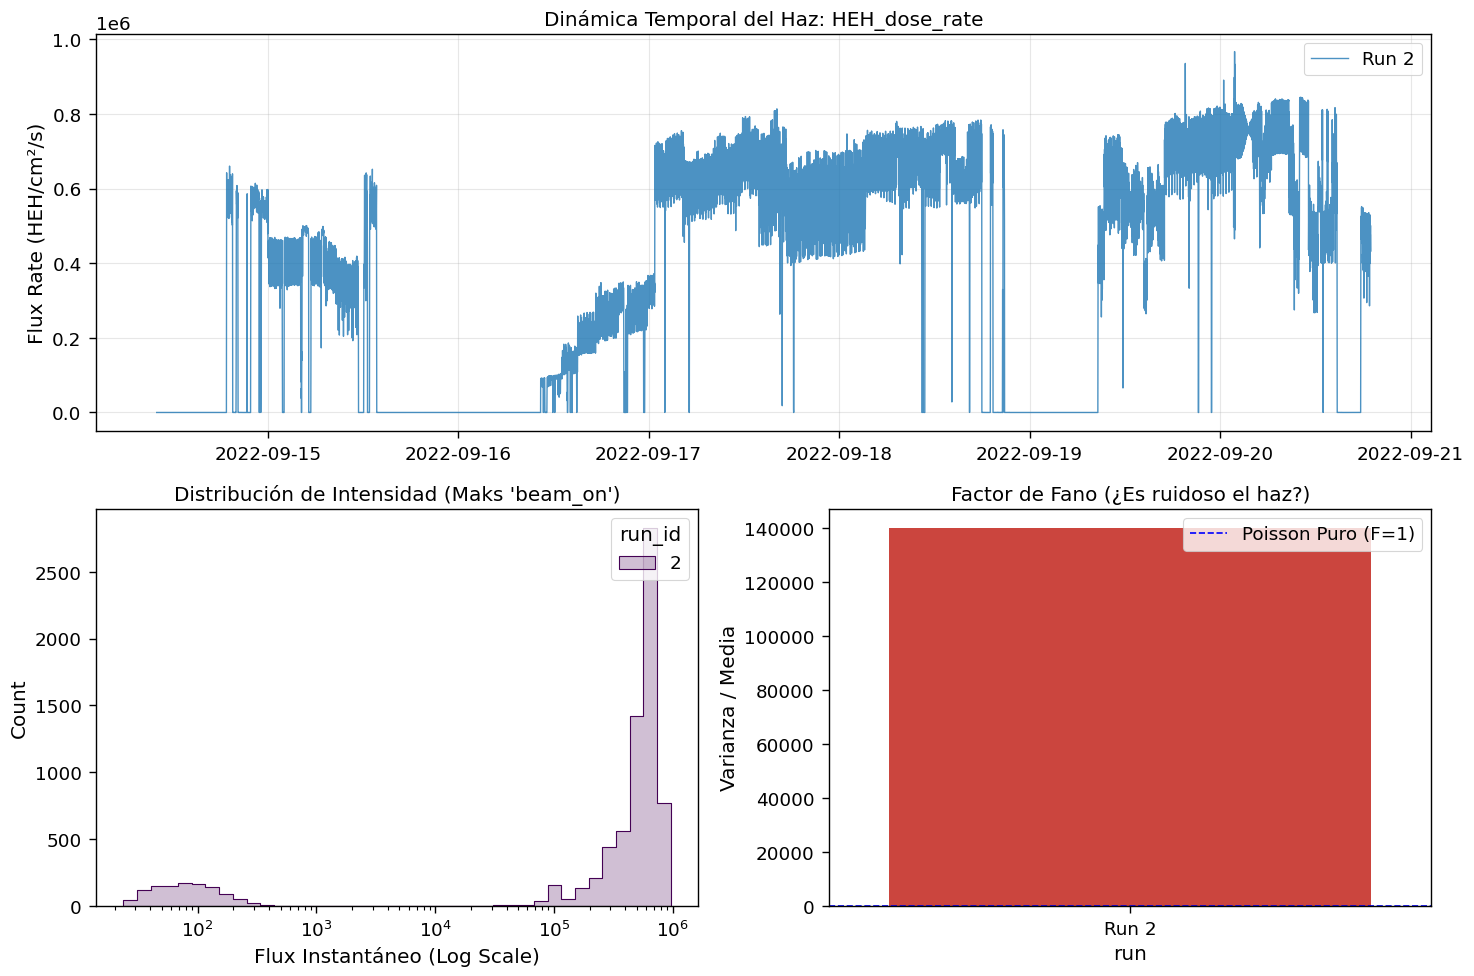


=== Informe de Diagnóstico del Haz ===
Método de filtrado de actividad: Maks 'beam_on'
[Run 2]
  - Flujo Promedio (durante spill): 4.66e+05 p/cm²/s
  - Factor de Fano: 140175.41
    ⚠️ CRÍTICO: Haz altamente irregular (Super-Poissoniano).
    Impacto: La probabilidad de fallos coincidentes (MBU/TMR defeat) es mayor a la teórica.


In [25]:
# Cell 3: Análisis de Estructura del Haz (Validación de Burstiness)
def analyze_beam_structure(df_b):
    print(f"--- Caracterización Física del Haz (Multi-Run) ---")
    
    # 1. Configuración de Variables
    flux_col = 'HEH_dose_rate'   # Tasa instantánea ya calculada
    fluence_col = 'HEH'          # Acumulado
    
    # Validación de integridad
    if flux_col not in df_b.columns:
        raise ValueError(f"Falta la columna crítica '{flux_col}'")
        
    # 2. Visualización Temporal (Comparativa Run 2 vs Run 3)
    run_ids = df_b['run_id'].unique()
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Evolución Temporal del Flujo Instantáneo
    plt.subplot(2, 1, 1)
    for r_id in sorted(run_ids):
        # Filtramos un subset para graficar, limpiando ceros para escala log si es necesario
        subset = df_b[df_b['run_id'] == r_id]
        if subset.empty: continue
            
        plt.plot(subset['timestamp'], subset[flux_col], 
                 label=f'Run {r_id}', alpha=0.8, linewidth=1)
        
    plt.ylabel("Flux Rate (HEH/cm²/s)")
    plt.title(f"Dinámica Temporal del Haz: {flux_col}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Histograma de Intensidad (Solo durante Beam ON)
    plt.subplot(2, 2, 3)
    
    # Usamos la bandera 'beam_on' para aislar la estadística del spill real
    if 'beam_on' in df_b.columns and df_b['beam_on'].sum() > 0:
        active_data = df_b[df_b['beam_on'] == 1]
        selection_method = "Maks 'beam_on'"
    else:
        # Fallback: Umbral del 1% del máximo si beam_on no es fiable
        thresh = df_b[flux_col].max() * 0.01
        active_data = df_b[df_b[flux_col] > thresh]
        selection_method = f"Umbral (> {thresh:.1e})"

    sns.histplot(data=active_data, x=flux_col, hue='run_id', bins=40, element="step", log_scale=True, palette="viridis")
    plt.title(f"Distribución de Intensidad ({selection_method})")
    plt.xlabel("Flux Instantáneo (Log Scale)")

    # Subplot 3: Violación de Poisson (Factor de Fano)
    plt.subplot(2, 2, 4)
    stats_list = []
    
    for r_id in sorted(run_ids):
        # Analizamos solo la parte estable del "Spill" (Alta intensidad)
        # Esto evita que los tiempos muertos (flux=0) inflen la varianza artificialmente
        run_active = active_data[active_data['run_id'] == r_id]
        
        if len(run_active) > 10:
            mean_val = run_active[flux_col].mean()
            var_val = run_active[flux_col].var()
            fano = var_val / mean_val if mean_val > 0 else 0
            stats_list.append({'run': f"Run {r_id}", 'Fano': fano, 'Mean': mean_val})
    
    if stats_list:
        df_stats = pd.DataFrame(stats_list)
        sns.barplot(data=df_stats, x='run', y='Fano', hue='run', palette="Reds_d", legend=False)
        plt.axhline(1.0, color='blue', linestyle='--', label='Poisson Puro (F=1)')
        plt.title("Factor de Fano (¿Es ruidoso el haz?)")
        plt.ylabel("Varianza / Media")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    # 3. Reporte Numérico
    print("\n=== Informe de Diagnóstico del Haz ===")
    print(f"Método de filtrado de actividad: {selection_method}")
    for stat in stats_list:
        print(f"[{stat['run']}]")
        print(f"  - Flujo Promedio (durante spill): {stat['Mean']:.2e} p/cm²/s")
        print(f"  - Factor de Fano: {stat['Fano']:.2f}")
        if stat['Fano'] > 10:
            print("    ⚠️ CRÍTICO: Haz altamente irregular (Super-Poissoniano).")
            print("    Impacto: La probabilidad de fallos coincidentes (MBU/TMR defeat) es mayor a la teórica.")

analyze_beam_structure(df_beam)

>>> GENERANDO ANÁLISIS DE RIESGO (MODO: FULL) <<<
Sesión Analizada: 0 | Duración: 9179.1 min
Total Muestras en Sesión: 9999


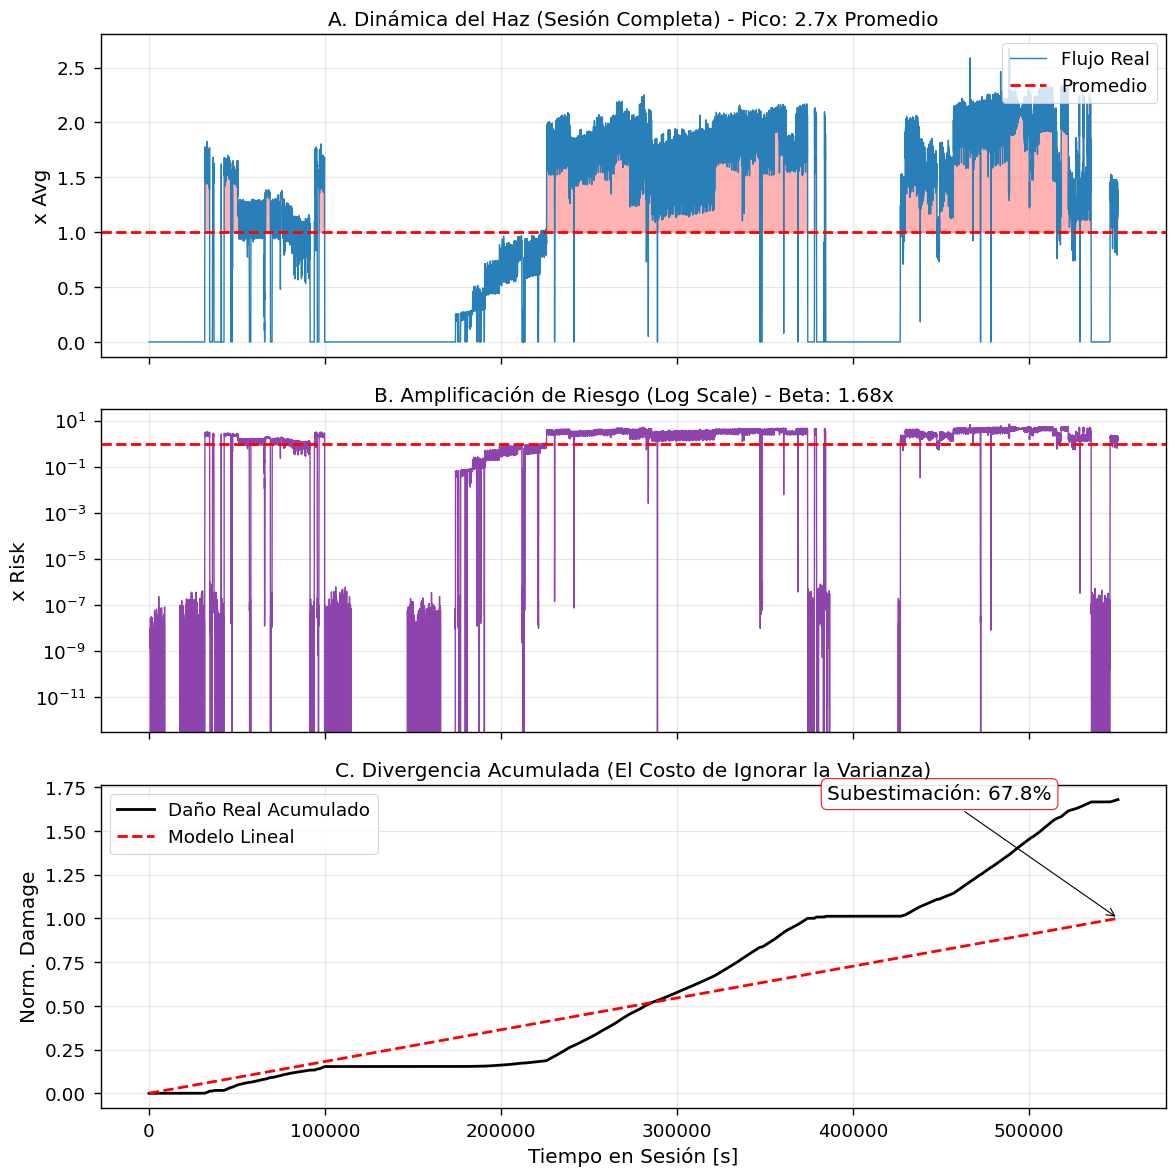


    === REPORTE JENSEN GAP (FULL) ===
    1. Factor Beta (Multiplicador de Riesgo): 1.68x
    2. Pico de Intensidad: 2.7x sobre el promedio
    3. Error del Modelo Promedio: 67.8% (Subestimación)
    
    CONCLUSIÓN: Usar el flujo promedio ignora el 67.8% del riesgo real.
    


In [36]:
# Cell 6 (Final): Análisis de Riesgo Panorámico (Full Session)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_risk_dynamics(df_b, view_mode='full', normalize=True, min_samples=100):
    """
    Analiza la divergencia de riesgo (Jensen Gap) en toda la sesión activa.
    
    Args:
        df_b: DataFrame con datos del haz.
        view_mode (str): 'full' para ver toda la sesión, 'zoom' para ver solo el pico.
        normalize (bool): Si True, ejes en veces-el-promedio (xAvg).
        min_samples (int): Mínimo de muestras para asegurar un gráfico legible.
    """
    print(f">>> GENERANDO ANÁLISIS DE RIESGO (MODO: {view_mode.upper()}) <<<")
    
    # --- 1. IDENTIFICACIÓN DE SESIÓN (Física) ---
    df_b = df_b.copy().sort_values('timestamp')
    df_b['dt'] = df_b['timestamp'].diff().dt.total_seconds().fillna(0)
    
    # Segmentar: Si pasa > 60s sin datos, es una nueva sesión (Beam OFF)
    df_b['session_id'] = (df_b['dt'] > 60).cumsum()
    
    # Elegir la sesión con más actividad (la más representativa)
    top_session_id = df_b['session_id'].value_counts().idxmax()
    df_sess = df_b[df_b['session_id'] == top_session_id].reset_index(drop=True)
    
    print(f"Sesión Analizada: {top_session_id} | Duración: {(df_sess['timestamp'].max() - df_sess['timestamp'].min()).total_seconds()/60:.1f} min")
    print(f"Total Muestras en Sesión: {len(df_sess)}")

    # --- 2. SELECCIÓN DE VISTA (Slicing) ---
    if view_mode == 'zoom':
        # Modo Microscopio: Centrado en el pico máximo
        max_idx = df_sess['HEH_dose_rate'].idxmax()
        # Tomamos al menos 'min_samples' alrededor del pico
        half_window = min_samples // 2
        start_idx = max(0, max_idx - half_window)
        end_idx = min(len(df_sess), max_idx + half_window)
        
        # Ajuste si estamos en los bordes
        if end_idx - start_idx < min_samples:
            if start_idx == 0: end_idx = min(len(df_sess), min_samples)
            if end_idx == len(df_sess): start_idx = max(0, len(df_sess) - min_samples)
            
        df_view = df_sess.iloc[start_idx:end_idx].copy()
        title_suffix = "(Zoom en Pico)"
    else:
        # Modo Panorámico: Toda la sesión
        df_view = df_sess.copy()
        title_suffix = "(Sesión Completa)"

    if df_view.empty:
        print("Error: No hay datos suficientes para visualizar.")
        return

    # Tiempo relativo para el eje X (empezando en 0)
    df_view['rel_time'] = (df_view['timestamp'] - df_view['timestamp'].iloc[0]).dt.total_seconds()

    # --- 3. CÁLCULO DE FÍSICA (Jensen Gap) ---
    # Usamos el promedio de la VISTA ACTUAL para la normalización local
    phi = df_view['HEH_dose_rate']
    phi_mean = phi.mean()
    if phi_mean <= 0: phi_mean = 1e-9 # Evitar div/0
    
    # RIESGO REAL (Modelo Cuadrático - Coincidencia)
    risk_real = phi ** 2
    
    # RIESGO MODELO (Modelo Lineal/Promedio)
    # Hipótesis: El ingeniero usa el promedio de esta ventana como constante
    risk_model_const = phi_mean ** 2
    risk_model_series = np.full_like(phi, risk_model_const)
    
    # Acumulados (Daño Total)
    cum_risk_real = risk_real.cumsum()
    cum_risk_model = pd.Series(risk_model_series).cumsum()

    # --- 4. MÉTRICAS CLAVE ---
    # Factor Beta: Cuánto más daño hace la realidad vs el modelo promedio
    # Beta = E[x^2] / (E[x])^2
    beta_factor = (phi**2).mean() / (phi_mean**2)
    
    # Pico vs Promedio
    peak_ratio = phi.max() / phi_mean
    
    # Déficit Final
    final_real = cum_risk_real.iloc[-1]
    final_model = cum_risk_model.iloc[-1]
    gap_pct = (final_real - final_model) / final_model * 100

    # --- 5. VISUALIZACIÓN ---
    # Preparamos unidades
    if normalize:
        y_A = phi / phi_mean
        y_B = risk_real / (phi_mean**2)
        # Normalizamos acumulada para que el Modelo termine en 1.0
        norm_C = final_model
        y_C_real = cum_risk_real / norm_C
        y_C_model = cum_risk_model / norm_C
        
        unit_A = "x Avg"
        unit_B = "x Risk"
        unit_C = "Norm. Damage"
        ref_line = 1.0
    else:
        y_A = phi
        y_B = risk_real
        y_C_real = cum_risk_real
        y_C_model = cum_risk_model
        unit_A = "Flux"
        unit_B = "Risk"
        unit_C = "Cum. Risk"
        ref_line = phi_mean

    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # PLOT A: Flujo (La Causa)
    ax0 = axes[0]
    ax0.plot(df_view['rel_time'], y_A, color='#2980b9', lw=1, label='Flujo Real')
    ax0.axhline(ref_line, color='red', ls='--', lw=2, label='Promedio')
    ax0.fill_between(df_view['rel_time'], y_A, ref_line, where=(y_A > ref_line), color='red', alpha=0.3)
    ax0.set_ylabel(unit_A)
    ax0.set_title(f"A. Dinámica del Haz {title_suffix} - Pico: {peak_ratio:.1f}x Promedio")
    ax0.legend(loc='upper right')
    ax0.grid(True, alpha=0.3)
    
    # PLOT B: Riesgo (El Efecto Cuadrático)
    ax1 = axes[1]
    ax1.plot(df_view['rel_time'], y_B, color='#8e44ad', lw=1, label='Riesgo Real ($\Phi^2$)')
    ax1.axhline(ref_line**2 if normalize else phi_mean**2, color='red', ls='--', lw=2, label='Riesgo Modelo')
    ax1.set_yscale('log') # Log scale vital para ver picos gigantes
    ax1.set_ylabel(unit_B)
    ax1.set_title(f"B. Amplificación de Riesgo (Log Scale) - Beta: {beta_factor:.2f}x")
    ax1.grid(True, alpha=0.3, which='both')
    
    # PLOT C: Acumulado (La Realidad vs Estimación)
    ax2 = axes[2]
    ax2.plot(df_view['rel_time'], y_C_real, color='black', lw=2, label='Daño Real Acumulado')
    ax2.plot(df_view['rel_time'], y_C_model, color='red', ls='--', lw=2, label='Modelo Lineal')
    
    # Anotación del Gap Final
    ax2.annotate(f'Subestimación: {gap_pct:.1f}%', 
                 xy=(df_view['rel_time'].iloc[-1], y_C_model.iloc[-1]), 
                 xytext=(df_view['rel_time'].iloc[-1]*0.7, y_C_real.iloc[-1]),
                 arrowprops=dict(facecolor='red', arrowstyle='->'),
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))
    
    ax2.set_ylabel(unit_C)
    ax2.set_xlabel("Tiempo en Sesión [s]")
    ax2.set_title("C. Divergencia Acumulada (El Costo de Ignorar la Varianza)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # --- REPORTING ---
    report = f"""
    === REPORTE JENSEN GAP ({view_mode.upper()}) ===
    1. Factor Beta (Multiplicador de Riesgo): {beta_factor:.2f}x
    2. Pico de Intensidad: {peak_ratio:.1f}x sobre el promedio
    3. Error del Modelo Promedio: {gap_pct:.1f}% (Subestimación)
    
    CONCLUSIÓN: Usar el flujo promedio ignora el {gap_pct:.1f}% del riesgo real.
    """
    print(report)
    return {"beta": beta_factor, "gap_pct": gap_pct}

# Ejecución por defecto en modo FULL para ver todo
if 'df_beam' in globals():
    stats = visualize_risk_dynamics(df_beam, view_mode='full')
else:
    print("Por favor cargue df_beam.")

Los números son contundentes. Un error de 67.8% en la estimación de riesgo no es una desviación estadística; es una ceguera sistémica. Si estuviéramos certificando un escudo térmico o un soporte vital, el modelo actual habría autorizado un diseño destinado al fallo catastrófico.El Siguiente Paso Lógico: Calibración de la "Física de Ráfagas"Ya sabemos qué está mal (usar promedios). 

Ahora debemos definir cómo inyectar la realidad en la simulación.No basta con multiplicar el resultado final por $1.68$. 

La dinámica temporal importa: un TMR no falla por acumulación lenta, falla por coincidencia instantánea. Necesitamos parametrizar el "ataque" para que run_simulation.py (o su futura versión 2.0) pueda replicarlo.Necesitamos extraer tres "Constantes de Batalla" de los datos:
- $\Phi_{active}$ (Active Flux): ¿Qué tan intenso es el haz mientras golpea? (Será mucho mayor que el promedio).
- $\delta$ (Duty Cycle): ¿Qué porcentaje del tiempo estamos bajo ataque?
- $\tau_{spill}$ (Spill Duration): ¿Cuánto dura el castigo continuo?

In [37]:
# Cell 7: Extracción de Parámetros de Simulación (Spill Calibration)
def extract_simulation_parameters(df_b):
    print(">>> CALIBRANDO PARÁMETROS PARA SIMULACIÓN DE RÁFAGAS <<<")
    
    # 1. Limpieza y Selección de Sesión Operativa
    # Usamos la misma lógica robusta: filtrar tiempos muertos largos
    df_b = df_b.copy().sort_values('timestamp')
    df_b['dt'] = df_b['timestamp'].diff().dt.total_seconds().fillna(0)
    df_b['session_id'] = (df_b['dt'] > 60).cumsum()
    
    # Tomamos la sesión más representativa (mayor cantidad de datos)
    top_sess = df_b['session_id'].value_counts().idxmax()
    df_sess = df_b[df_b['session_id'] == top_sess].copy()
    
    # 2. Definición de "Actividad" (Spill Detection)
    # Un spill se define como cualquier momento donde el flujo supera 
    # significativamente el ruido de fondo.
    # Usamos un umbral dinámico: 10% del pico máximo observado en la sesión.
    # (Esto es estándar en física de aceleradores para definir FWHM o similar)
    flux = df_sess['HEH_dose_rate']
    threshold = flux.max() * 0.10
    
    is_spill = flux > threshold
    
    # 3. Cálculo de Parámetros Físicos
    # A. Duty Cycle: Proporción de tiempo activo
    # Duty = (Muestras Activas) / (Total Muestras en Sesión)
    # Nota: Asumiendo dt constante. Si dt varía mucho, se debe ponderar por dt.
    total_duration = df_sess['dt'].sum()
    active_duration = df_sess.loc[is_spill, 'dt'].sum()
    
    duty_cycle = active_duration / total_duration
    
    # B. Active Flux (Intensidad de Combate)
    # Promedio del flujo SOLO cuando is_spill es True
    flux_active_mean = flux[is_spill].mean()
    flux_global_mean = flux.mean()
    
    # C. Factor de Compresión (Compression Ratio)
    # Cuántas veces mayor es el flujo activo respecto al promedio que usábamos antes.
    compression_ratio = flux_active_mean / flux_global_mean
    
    # D. Duración Típica del Spill
    # Agrupamos los 'True' consecutivos para medir cuánto duran los pulsos
    spill_groups = (is_spill != is_spill.shift()).cumsum()
    spill_durations = df_sess[is_spill].groupby(spill_groups)['dt'].sum()
    avg_spill_duration = spill_durations.mean()
    
    # --- SALIDA DE DATOS ---
    report = f"""
=== PARÁMETROS DE CALIBRACIÓN (SESIÓN {top_sess}) ===

1. ANATOMÍA DEL HAZ:
   - Flujo Promedio Global (El error): {flux_global_mean:.2e} p/cm²/s
   - Flujo Activo Real (La verdad):   {flux_active_mean:.2e} p/cm²/s
   -> FACTOR DE CORRECCIÓN DE FLUJO:  {compression_ratio:.2f}x
      (Debe simular con un flujo {compression_ratio:.1f} veces mayor al promedio)

2. TEMPORIZACIÓN:
   - Duty Cycle (Ciclo de Trabajo):   {duty_cycle*100:.2f}%
   - Duración Promedio de Spill:      {avg_spill_duration:.3f} s
   
3. INSTRUCCIÓN PARA LA SIMULACIÓN:
   En lugar de simular 30 segundos continuos a {flux_global_mean:.1e},
   debe simular 'micro-eventos' de {avg_spill_duration:.2f}s a una intensidad de {flux_active_mean:.1e}.
   
   La probabilidad de fallo instantáneo (P ~ Phi^2) aumentará por un factor de:
   ({compression_ratio:.2f})^2 = {compression_ratio**2:.2f}x durante el spill.
=====================================================
    """
    print(report)
    
    return {
        "flux_active": flux_active_mean,
        "duty_cycle": duty_cycle,
        "spill_duration": avg_spill_duration,
        "compression_ratio": compression_ratio
    }

# Ejecutar extracción
params = extract_simulation_parameters(df_beam)

>>> CALIBRANDO PARÁMETROS PARA SIMULACIÓN DE RÁFAGAS <<<

=== PARÁMETROS DE CALIBRACIÓN (SESIÓN 0) ===

1. ANATOMÍA DEL HAZ:
   - Flujo Promedio Global (El error): 3.61e+05 p/cm²/s
   - Flujo Activo Real (La verdad):   5.53e+05 p/cm²/s
   -> FACTOR DE CORRECCIÓN DE FLUJO:  1.53x
      (Debe simular con un flujo 1.5 veces mayor al promedio)

2. TEMPORIZACIÓN:
   - Duty Cycle (Ciclo de Trabajo):   65.11%
   - Duración Promedio de Spill:      6520.109 s
   
3. INSTRUCCIÓN PARA LA SIMULACIÓN:
   En lugar de simular 30 segundos continuos a 3.6e+05,
   debe simular 'micro-eventos' de 6520.11s a una intensidad de 5.5e+05.
   
   La probabilidad de fallo instantáneo (P ~ Phi^2) aumentará por un factor de:
   (1.53)^2 = 2.35x durante el spill.
    
